# Time Series Analysis with AR(p) Models

In this notebook we are going to discuss the use of the AR(p) model to make predictions for time series data.

# Overview:

The general process involved is as follows:
1. ETL the data (get it in the correct format and make sure all the data points have the correc type)
2. Check if the data has the right characteristics for our model
3. Transform the data so that it has the right characteristics (if necessary)
4. Segment our data into test and train segments
5. Define the model
6. Choose parameter p for the model by looking at the Autocorrelation function
7. Train the model by fitting it to a subset of the available data
8. Test the model performance by making predictions using another subset of available data

We will examine each step along this process

# 1. ETL the data
In this step we want to Load the data into memory so that we can work with it. This may require that the data be Extracted from a collection of irrelevant data and it may require that the data be Transformed from one type into another so that it can be understood by our data science software.

In [1]:
# Import libraries to manipulate data
import pandas
import numpy 
import matplotlib.pyplot as pyplot

We have tried to make this notebook readable and clean. As a result, some helpful utilities have been stored in a separate .py file and loaded into this notebook as a library.

In [2]:
# Import the utilities module we wrote
import importlib.util
spec = importlib.util.spec_from_file_location("utilities", "../../Utilities/utilities.py")
utilities = importlib.util.module_from_spec(spec)
spec.loader.exec_module(utilities)

Our data file has data from the entier market. We will Extract only data for the specific stock that we want to model. We will then Transform that date column into an date object so we can understand it correctly

In [5]:
# Read the file into a dataframe
file_path = "../../nasdaq_2019.csv"
converter_mapping = {
    "date": utilities.convert_date_string_to_date
}
pandas_dataframe = pandas.read_csv(file_path, converters=converter_mapping)

# Sort based on the date column
pandas_dataframe = pandas_dataframe.sort_values("date")

# Filter out data for a specific ticker
aaba_dataframe = pandas_dataframe.loc[pandas_dataframe.ticker == "AABA"]

# Filter down to the last month of data
# aaba_dataframe = aaba_dataframe.loc[aaba_dataframe["date"] > '2019-07-01']

# Remove unwanted columns
aaba_dataframe = aaba_dataframe[["date","open"]]

# Reset the index
aaba_dataframe.index = range(0, aaba_dataframe.shape[0])

# Show the first few rows
aaba_dataframe.shape

(158, 2)

Lets have a look at our data

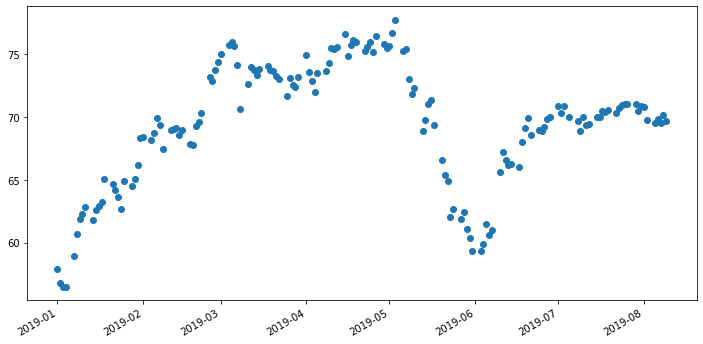

In [6]:
figure, axis = utilities.plot_dataframe(aaba_dataframe, "date", "open")

# 2. Check if the data has the right characteristics for our model

We plan on using the AR(p) model to make predictions for our data. This model has two requirements for the data:
1. stationarity - a constant mean, variance, and autocorrelation
2. ergodicity - when every sequence or sizable sample is equally representative of the whole

So we will need to check if these two conditions are met


## 2.1 Check data for stationarity

A stationary process has the property that the mean, variance and autocorrelation structure do not change over time. Stationarity can be defined in precise mathematical terms, but for our purpose we mean a flat looking series, without trend, constant variance over time, a constant autocorrelation structure over time and no periodic fluctuations (seasonality).

Roughly speaking, stationarity says that the distribution of XtXt looks the same at different locations tt. This allows us to do statistical inference by treating the stochastic process as multiple correlated draws from the same distribution.

Of course, many stochastic processes are obviously not stationary. By transforming nonstationary processes so that they are stationary, we may gain information about the overall trends in the process and can use the theory of stationary processes for analysis, fitting, and prediction.

There are basically three often used approaches to make time series stable based on three difference scenarios: 
1. first difference for linear trend
2. log for non-linear trend
3. log seasonal difference for seasonality

We will look atthese and a few more

In [7]:
mean_var_df = utilities.calculate_moving_mean_and_std(aaba_dataframe, "open")

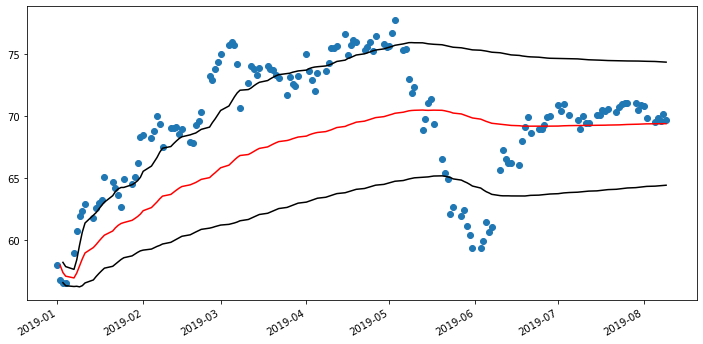

In [8]:
figure, axis = utilities.plot_dataframe(aaba_dataframe, "date", "open")
utilities.plot_moving_mean_and_std_for_dataframes(mean_var_df, "date", axis)

We can see that our data is not stationary. We will need to transform the data so that it is stationary.

## 2.2 Check data for ergodicity
We wont get into this here. We can take random samples and do QQ plots. I will write some notebooks on this in the future.

# 3. Transform the data so that it has the right characteristics (if necessary)


## 3.1 Stationary Transform
The AR(p) model requires stationary data. Let's see if we can make the data stationary without removing the autocorrelation.

### 3.1.1 Differencing
We saw previously that our data is NOT stationary and we will need to fix that. There are several methods for making data stationary, we will use differencing.

In [9]:
aaba_dataframe["diff"] = aaba_dataframe["open"].diff()
aaba_dataframe.at[0, "diff"] = 0
aaba_dataframe["diff"] = aaba_dataframe["diff"].fillna(0)
aaba_dataframe.shape

(158, 3)

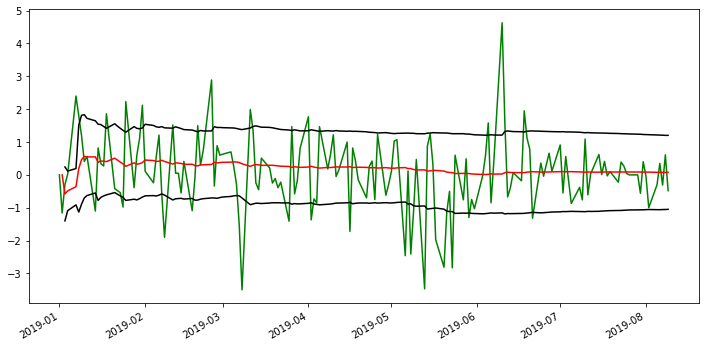

In [10]:
figure, axis = utilities.plot_dataframe(aaba_dataframe, "date", "diff", scatter=False, line=True)
mean_var_df = utilities.calculate_moving_mean_and_std(aaba_dataframe, "diff")
utilities.plot_moving_mean_and_std_for_dataframes(mean_var_df, "date", axis)

### 3.1.2 Returns

In [11]:
aaba_dataframe["ret"] = aaba_dataframe["open"]/aaba_dataframe["open"].shift(-1)
aaba_dataframe.at[0, "ret"] = 0
aaba_dataframe["ret"] = aaba_dataframe["ret"].fillna(0)
aaba_dataframe.shape

(158, 4)

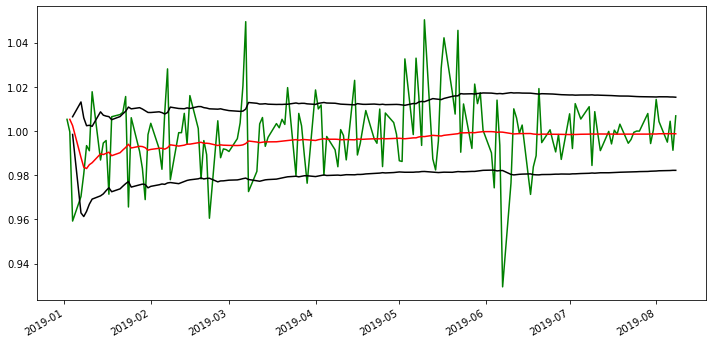

In [12]:
figure, axis = utilities.plot_dataframe(aaba_dataframe[1:-1], "date", "ret", scatter=False, line=True)
mean_var_df = utilities.calculate_moving_mean_and_std(aaba_dataframe[1:-1], "ret")
utilities.plot_moving_mean_and_std_for_dataframes(mean_var_df, "date", axis)

### 3.1.3 Log Returns

Let have a look at the log returns

In [13]:
aaba_dataframe["log"] = numpy.log(aaba_dataframe["ret"])
aaba_dataframe.at[0, "log"] = 0
aaba_dataframe["log"] = aaba_dataframe["log"].fillna(0)
aaba_dataframe.shape

c:\program files\python\python 3.8\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(158, 5)

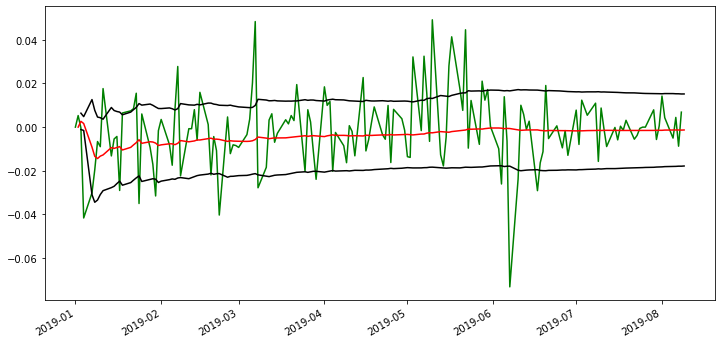

In [14]:
figure, axis = utilities.plot_dataframe(aaba_dataframe, "date", "log", scatter=False, line=True)
mean_var_df = utilities.calculate_moving_mean_and_std(aaba_dataframe, "log")
utilities.plot_moving_mean_and_std_for_dataframes(mean_var_df, "date", axis)

### 3.1.4 Log-Returns Squared

In [15]:
aaba_dataframe["sqr"] = aaba_dataframe["ret"]**2
aaba_dataframe.at[0, "sqr"] = 0
aaba_dataframe["sqr"] = aaba_dataframe["sqr"].fillna(0)
aaba_dataframe.shape

(158, 6)

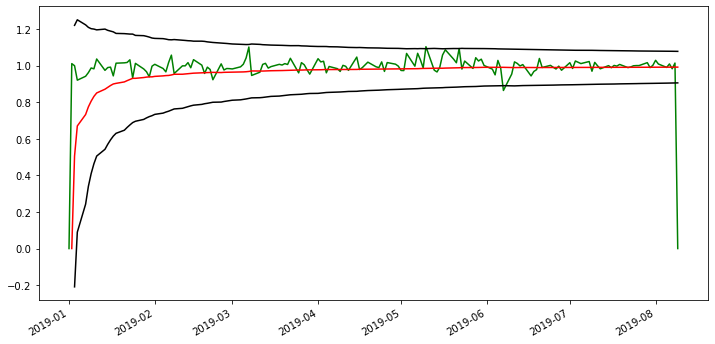

In [16]:
figure, axis = utilities.plot_dataframe(aaba_dataframe, "date", "sqr", scatter=False, line=True)
mean_var_df = utilities.calculate_moving_mean_and_std(aaba_dataframe, "sqr")
utilities.plot_moving_mean_and_std_for_dataframes(mean_var_df, "date", axis)

### 3.1.5 De-Trending
We will subtract the mean from the data to remove the trend

In [17]:
mean_var_df = utilities.calculate_moving_mean_and_std(aaba_dataframe, "open")
aaba_dataframe["de-trend"] = aaba_dataframe["open"] - mean_var_df["mean"]
aaba_dataframe["de-trend"] = aaba_dataframe["de-trend"].fillna(0)
aaba_dataframe.shape

(158, 7)

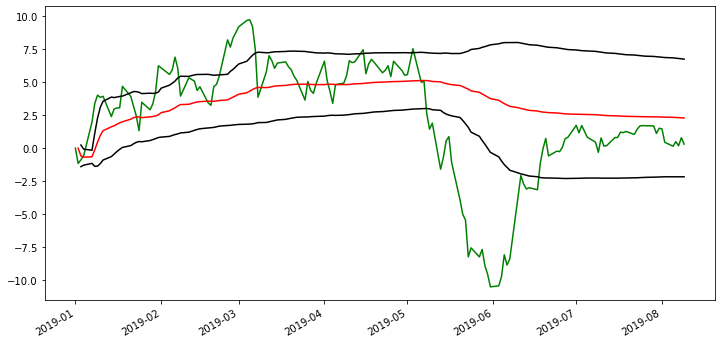

In [18]:
figure, axis = utilities.plot_dataframe(aaba_dataframe, "date", "de-trend", scatter=False, line=True)
mean_var_df = utilities.calculate_moving_mean_and_std(aaba_dataframe, "de-trend")
utilities.plot_moving_mean_and_std_for_dataframes(mean_var_df, "date", axis)

### 3.1.6 Normalizing

In [19]:
mean_var_df = utilities.calculate_moving_mean_and_std(aaba_dataframe, "open")
aaba_dataframe["norm"] = (aaba_dataframe["open"] - mean_var_df["mean"]) / mean_var_df["std"]
aaba_dataframe["norm"] = aaba_dataframe["norm"].fillna(0)
aaba_dataframe.shape

(158, 8)

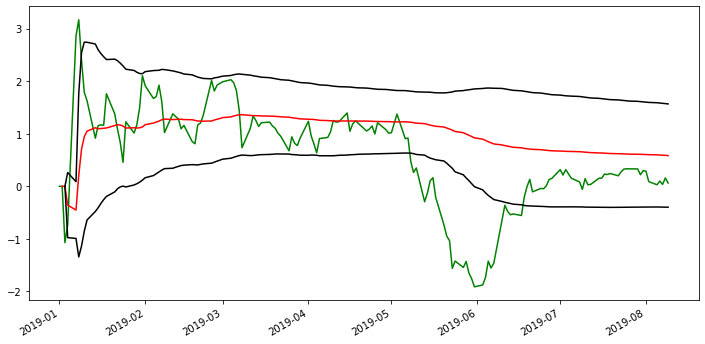

In [20]:
figure, axis = utilities.plot_dataframe(aaba_dataframe, "date", "norm", scatter=False, line=True)
mean_var_df = utilities.calculate_moving_mean_and_std(aaba_dataframe, "norm")
utilities.plot_moving_mean_and_std_for_dataframes(mean_var_df, "date", axis)

# 4. Segment our data into test and train segments

In [21]:
# Determine how many data points to use for testing
percentage_for_training = 0.7
percentage_for_testing = 1 - percentage_for_training
datapoint_count = aaba_dataframe["open"].shape[0]
datapoints_for_training = int(percentage_for_training * datapoint_count)
datapoints_for_testing = int(percentage_for_testing * datapoint_count)


print("There are {0} datapoints for training.".format(datapoints_for_training))
print("There are {0} datapoints for testing.".format(datapoints_for_testing))

# Split our data into separate Series
#train = aaba_dataframe["diff"][0:datapoints_for_testing]
#test = aaba_dataframe["diff"][datapoints_for_testing:] 

There are 110 datapoints for training.
There are 47 datapoints for testing.


# 5. Define the model

## 5.1 General Definition of AR(p)

The AR model has a parameter p which indicates the numberof "lag terms" to consider in the model

$$ X_t = c+\sum\limits^p_{i=1}\psi_iX_{t-i}+\epsilon_t $$

## 5.2 Definition of AR(1)

The first order autoregressive model AR(1) is a recursive equation which only considers the previous term:

$$ y_t = \psi y_{t-1}+\epsilon_t $$

Note: The constant has been omitted for simplicity

The coefficient $\psi$, sometimes called a weight, indicates the relative importance of the term. 

The term $\epsilon$ represents an error term; the difference between our previous estimation and the actual observed value at time t.

Depending on the value of $\psi$ our model is named different things. With $|\psi|<1$ we have what's called a causal AR model where the values are time dependent.


## 5.3 Theoretical Properties of the AR model

1. $ \epsilon_t \overset{i.i.d}{\sim} N(0,\sigma^2_\epsilon) $
2. $y_0$ is known

# 6. Choose parameter p by looking at the Autocorrelation function

The Autocorrelation function returns the correlation of a function with it's lagged values. The input to the function is the size of the lag; the number of datapoints between the current data and the previous data being examined.

The purpose of looking at the function is to choose a model which maximizes the usage of autocorrelated lags.

A pandas Series has a built in function to calculate Autocorrelation
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.autocorr.html

In [22]:
lags = range(1, 30)
autocorrelations_open = [aaba_dataframe["open"].autocorr(lag) for lag in lags]
autocorrelations_diff = [aaba_dataframe["diff"].autocorr(lag) for lag in lags]
autocorrelations_ret = [aaba_dataframe["ret"].autocorr(lag) for lag in lags]
autocorrelations_log = [aaba_dataframe["log"][1:-1].autocorr(lag) for lag in lags] # Remove bad values
autocorrelations_sqr = [aaba_dataframe["sqr"][1:-1].autocorr(lag) for lag in lags]
autocorrelations_trend = [aaba_dataframe["de-trend"][1:-1].autocorr(lag) for lag in lags]

df = pandas.DataFrame({
    "lags":lags, 
    "open": autocorrelations_open,
    "diff": autocorrelations_diff,
    "ret": autocorrelations_ret,
    "log": autocorrelations_log,
    "sqr": autocorrelations_sqr,
    "de-trend": autocorrelations_trend
})

df = df.fillna(0)

df.head()

,lags,open,diff,ret,log,sqr,de-trend
0,1,0.973922,0.066479,-0.016907,0.082304,0.079371,0.968173
1,2,0.943852,-0.008730,0.000267,-0.001555,0.004937,0.933212
2,3,0.913443,0.035728,0.028713,0.053780,0.055534,0.899583
3,4,0.880094,0.053865,0.028130,0.074230,0.076270,0.865193
4,5,0.842473,0.022021,0.007654,0.029397,0.036424,0.829441


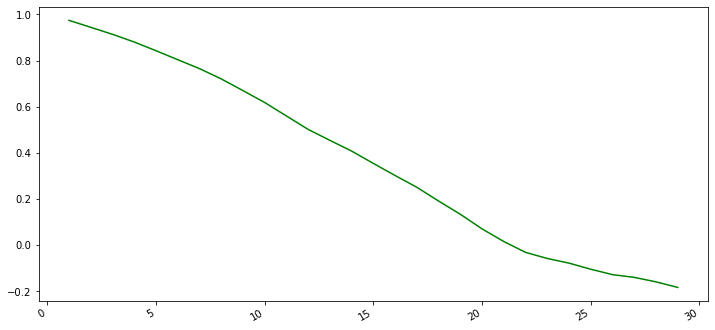

In [23]:
figure, axis = utilities.plot_dataframe(df, "lags", "open", scatter=False, line=True)

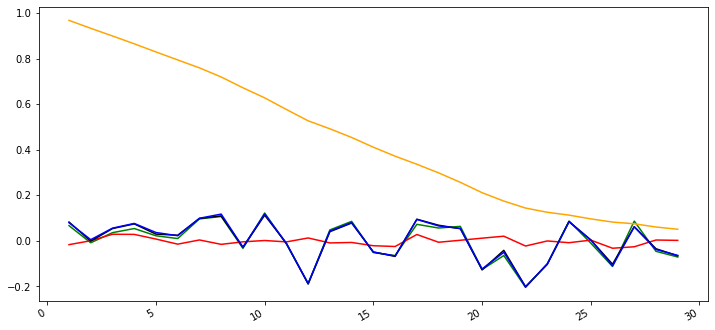

In [24]:
figure, axis = utilities.plot_dataframe(df, "lags", "diff", scatter=False, line=True)
axis.plot(df["lags"], df["ret"], color="red")
axis.plot(df["lags"], df["log"], color="black")
axis.plot(df["lags"], df["sqr"], color="blue")
axis.plot(df["lags"], df["de-trend"], color="orange")

# 7. Train the model by fitting it to a subset of the available data

## 7.1 Fitting Techniques

Training a model is another way of saying "fitting a model" or "optimizing a model". There are many fitting techniques we can use. As with any model or machine learning problem, we will look to minimize or maximize some function which explains our error or accuracy respectively.

There are three common methods for training the AR(p) model:
1. Ordinary Least Squares (OLE)
2. Maximum Likelihood Estimation (MLE)
3. Yule-Walker Equations

## 7.2 What is likelihood

The MLE technique relies on optimizing likelihood. So it is important for us to understand the concept.

The a probability expresses a ratio or percentage; the number of outcomes which match a particular criteria relative to the total number of possible outcomes. The probabilitiy that X = 5 is 43.5% for example. This probability is based on assumption about the underlying probability distribution.

We can compare assumptions of the distribution against other assumptions we could make. We can varry the parameters of the model and then calculate the probability that X = 5. By doing so we are talking about likelihood. We would say that one assumption has a higher likelihood of being the actual distribution relative to another.

## 7.3 Maximum Likelihood Estimation (MLE)

The MLE technique revolves around specifying a likelihood function (a function to output a the likelihood of a set of parameters yielding a particular result) and then optimizing that function by finding the parameters which yield the highest likelihood.

There are two types of MLE and they are formulated in a similar fashion. We will be using the conditional MLE as opposed to the exact MLE. The exact MLE is difficult to construct to do physical limitations in the real world and does not produce good results for stationary data 

# 7.4 Deriving the likelihood function

In classical literature the parameters of the likelihood function are represented as a vector named $\theta$. In the case of the AR(1) model, the parameters would be expressed as:

$$ \theta = (\psi) $$

Note: The other variables in the AR(1) model are fixed and do not varry which is why they are not included in the parameter set



We know that our likelihood function will be described as the optimal distribution function. So our next step is to find a probability density function which accepts our parameters so we can optimize it.

As all our parameters are expressed through the vector $\theta$ we can use $f_\theta$ to represent our distribution function.

As the model is recursive it depends on previous terms. Extrapolating, we see the values of the terms $y_t$ depend on the value $y_{t-1}$ which depend on the value of $y_{t-2}$ and so on. As such we might express the density function as a conditional density function such that:

$$ f_\theta(\cdot) := f_\theta(y_t,..., y_1|y_0) $$

Here we see that our qeustion is conditional based on the first term. Changing the first term would change the value of the entire series as the model is time-dependent. This is the difference between the CMLE and EMLE.

We can exploit the recursive nature of the autoregressive model to derive a more informative conditional density function using Bayes Theorem:

$$ P(A|B)= \frac{P(A \cap B)}{P(B)} = \frac{P(B \cap A)}{P(B)}$$

Applying this to $f_\theta$, we derivethe following:

$$ f_\theta(y_t,..., y_1|y_0) = \frac{f(y_t,...y_0)}{f_\theta(y_0)} $$

Focusing on the numerator of the fraction, we can again employ Bayes and begin expanding the term using the identity $P(A \cap B) = P(A | B)P(B)$:

$$ f_\theta(y_t,...y_0) = f_\theta(y_t| y_{t-1},...,y_0) \underline{f_\theta(y_{t-1},...,y_0)} $$

If we focus on the underlined expression we can decompose the union of these terms (again using Bayes)


$$ \underline{f_\theta(y_{t-1},...,y_0)} $$

$$=  f_\theta(y_{t-1}|y_{t-2},...y_0)f(y_{t-2},...y_0) $$

$$ =  f_\theta(y_{t-1}|y_{t-2},...y_0)f(y_{t-2}|y_{t-3},...y_0)f(y_{t-3},...y_0)... $$

$$ =  f_\theta(y_{t-1}|y_{t-2},...y_0)f(y_{t-2}|y_{t-3},...y_0)f(y_{t-3}|y_{t-4},...y_0)f(y_{t-4},...y_0)... $$


We can simplify this sprawling equation by expressing it as a recursive product: 

$$f_\theta(y_t,...y_0) = \prod\limits^t_{t=1}f_\theta(y_t|y_{t-1},...,y_0)f_\theta(y_0)$$


We can further simplify the equation by studdying the definition of our model. There is only a relationship defined between $y_t$ and $y_{t-1}$ and therefore we can make the following assertion:

$$ y_t | y_{t-1},...y_0 \ \ \overset{D}{=} \ \  y_t | y_{t-1}$$

As such, it reasonably follows that:

$$ f_\theta(y_t | y_{t-1},...y_0) = f_\theta(y_t | y_{t-1})$$

And so our product becomes even simpler:

$$f_\theta(y_t,...y_0) = \prod\limits^t_{t=1}f_\theta(y_t|y_{t-1})f_\theta(y_0)$$

If we insert this back into our original equation we would have:

$$ f_\theta(y_t,..., y_1|y_0) = \frac{f(y_t,...y_0)}{f_\theta(y_0)} $$

$$ f_\theta(y_t,..., y_1|y_0) = \frac{\prod\limits^t_{t=1}f_\theta(y_t|y_{t-1})f_\theta(y_0)}{f_\theta(y_0)} $$

$$ f_\theta(y_t,..., y_1|y_0) = \prod\limits^t_{t=1}f_\theta(y_t|y_{t-1}) $$

https://www.youtube.com/watch?v=fxEjTvG24XM

At this point we have derived a function that is simple enough for us to attach a distribution and arrive at a closed form numerical solution.

Looking at our model, the equation would be deterministic if it wasnt for the noise term $\epsilon$. As this is the only random variable in our equation, the distribution which describes $f_\theta(\cdot)$ will be the same distribution with slightly modified parameters.

$$ y_t \sim N(\mu_y, \sigma^2_y) $$

We can now apply the definition of the normal distribution function to our conditional density function and finally derive our closed form solution:

$$ \large \phi(\mu,\sigma^2) = \frac{1}{\sigma\sqrt{2\pi}}e^{- \frac{1}{2} \left( \frac{x-\mu}{\sigma}  \right) ^2 }$$

$$ \large f_\theta(y_t|y_{t-1}) = \phi(\mu_y,\sigma_y^2) $$

$$ \Large = \frac{1}{\sigma_y\sqrt{2\pi}}e^{- \frac{1}{2} \left( \frac{y_t-\mu_y}{\sigma_y}  \right) ^2 } $$


Plugging this solution back into our equation we arrive at a closed form of the likelihood function:

$$ \large \mathcal{L} = f_\theta(y_t,..., y_1|y_0) = \prod\limits^n_{t=1} \frac{1}{\sigma_y\sqrt{2\pi}}e^{- \frac{1}{2} \left( \frac{y_t-\mu_y}{\sigma_y}  \right) ^2 } $$

$$ \large =  \left( \frac{1}{\sigma_y\sqrt{2\pi}} \right)^{n-1} \prod\limits^n_{t=1} e^{- \frac{1}{2} \left( \frac{y_t-\mu_y}{\sigma_y}  \right) ^2 }$$

$$ \large =  \left( \frac{1}{\sigma_y\sqrt{2\pi}} \right)^{n-1} e^{ \sum\limits^n_{t=1} - \frac{1}{2 \sigma^2_y} \left( y_t-\mu_y \right) ^2 }$$

$$ \large =  \left( \frac{1}{\sigma_y\sqrt{2\pi}} \right)^{n-1} e^{- \frac{1}{2 \sigma^2_y} \sum\limits^n_{t=1} \left( y_t-\mu_y \right) ^2 }$$

$$ \large =  \left( \frac{1}{\sigma_y\sqrt{2\pi}} \right)^{n-1} e^{- \frac{1}{2 \sigma^2_y} \sum\limits^n_{t=1} \left( y_t-\mu_y \right) ^2 }$$

Because it can be numerically difficult to maximize a product of percentages (one small value can make dominate the entire product), it is almost always easier to use the log likelihood function ln(L).

$$ \large ln(\mathcal{L}) = ln \left( \left( \frac{1}{\sigma_y\sqrt{2\pi}} \right)^{n-1} e^{- \frac{1}{2 \sigma^2_y} \sum\limits^n_{t=1} \left( y_t-\mu_y \right) ^2 } \right) $$

$$ \large  = ln \left( \left( \frac{1}{\sqrt{2\pi \sigma_y^2}} \right)^{n-1} \right) +  ln\left( e^{- \frac{1}{2 \sigma^2_y} \sum\limits^n_{t=1} \left( y_t-\mu_y \right) ^2 } \right) $$

$$ \large  = ln \left( \left( 2\pi \sigma_y^2 \right)^\frac{n-1}{2} \right) -  \frac{1}{2 \sigma^2_y} \sum\limits^n_{t=1} \left( y_t-\mu_y \right) ^2  $$

$$ \large  = \left( \frac{n-1}{2} \right) ln \left( 2\pi \sigma_y^2 \right) -  \frac{1}{2 \sigma^2_y} \sum\limits^n_{t=1} \left( y_t-\mu_y \right) ^2  $$

$$ \large  = \left( \frac{n-1}{2} \right) ln \left( 2\pi \right) - \left( \frac{n-1}{2} \right)ln(\sigma_y^2)  -  \frac{1}{2 \sigma^2_y} \sum\limits^n_{t=1} \left( y_t-\mu_y \right) ^2  $$

https://notes.quantecon.org/submission/5b3b102eb9eab00015b89f8e

http://www.ams.sunysb.edu/~zhu/ams586/Estimation%20of%20Stationary%20Time%20Series.pdf


If we apply the defintion of expected value to our equation $ y_t = \psi y_{t-1}+\epsilon_t $ we would have:

$$ \mu_y = \mathop{\mathbb{E}}[y_t]= \mathop{\mathbb{E}}[\psi y_{t-1}+\epsilon_t]  $$

$$ = \mathop{\mathbb{E}}[\psi y_{t-1}] + \mathop{\mathbb{E}}[\epsilon_t]  $$

$$ = \psi y_{t-1} $$

Applying the definition of variance we have:

$$ \sigma_y^2 = \mathop{\mathbb{Var}}[y_t]= \mathop{\mathbb{Var}}[\psi y_{t-1}+\epsilon_t]  $$

$$ = \mathop{\mathbb{Var}}[\psi y_{t-1}]+ \mathop{\mathbb{Var}}[\epsilon_t] $$

$$ = \mathop{\mathbb{Var}}[\epsilon_t] $$

$$ = \sigma^2_\epsilon $$

Whieh yields:

$$ \large  = \left( \frac{n}{2} \right) ln \left( 2\pi \right) - \left( \frac{n}{2} \right) ln(\sigma_\epsilon^2) - \frac{1}{2 \sigma^2_\epsilon} \sum\limits^n_{t=1} \left( y_t- \psi y_{t-1} \right) ^2  $$

# 7.4 Coding the likelihood function
In this section we will see that we can code the likelihood function ourselves based on the matematical formula above. While we arrive at the correct answer, the computation time is far greater and our acuracy is far lower than the "canned" functions provided by 3rd party libraries.

In [25]:
# Calculate our epsilons
def calculate_epsilons(time_series, psi):
    T = time_series.shape[0]
    epsilons = [0]
    for t in range(1, T):
        espilon = time_series[t] - psi * time_series[t - 1]
        epsilons.append(espilon)
    return numpy.array(epsilons)

In [26]:
# Write a function to help calculate the sum term in the likelihood function
def calculate_sum_term(time_series, phi):
    n = time_series.shape[0]
    total = 0
    for t in range(1, n):
        total += (time_series[t] - phi * time_series[t-1])**2
    return total

In [27]:
# Write a function to calculate the likelihood
def calculate_likelihood(time_series, phi):
    n = time_series.shape[0]
    
    epsilons = calculate_epsilons(time_series, phi)
    
    epsilon_sigma_sqr = epsilons.var()
    epsilon_mean = epsilons.mean()
    
    term1 = ((n - 1) / 2) * numpy.log(2 * numpy.pi)
    term2 = ((n - 1) / 2) * epsilon_sigma_sqr
    sum_term = calculate_sum_term(time_series, phi)
    term3 = (1 / (2 * epsilon_sigma_sqr)) * sum_term

    return  - term1 - term2 - term3

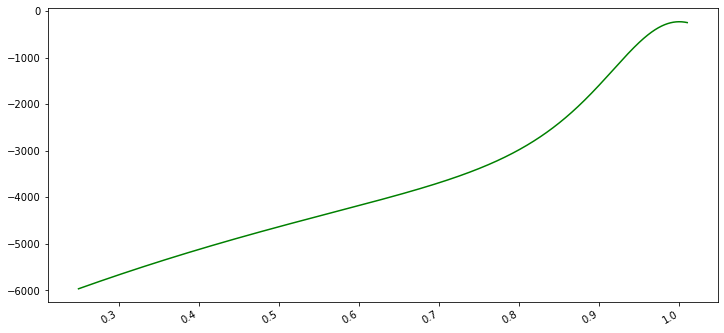

In [28]:
# Put all our functions together and show the likelihood curve for different values of alpha

phis = numpy.arange(0.25,1.01,0.0001)
likelihoods = [calculate_likelihood(aaba_dataframe["open"][0:datapoints_for_training], phi) for phi in phis]

df = pandas.DataFrame({
    "phis": phis,
    "likelihoods": likelihoods    
})

figure, axis = utilities.plot_dataframe(df, "phis", "likelihoods", scatter=False, line=True)

In [29]:
# Determine the psi that yields the maximum likelihood
m = df["likelihoods"].max()
df.loc[df["likelihoods"] == m,["phis","likelihoods"]]

,phis,likelihoods
7499,0.9999,-231.863459


There are many numerical and analytical solutions we can employ to derive this parameter value but we will not concern ourselves with that here. For more information consider researching optimization techniques.

# 7.5 Use 3rd party library

Now we will have a look at a 3rd party library which can optimize the likelihood function for us

In [30]:
# https://machinelearningmastery.com/make-manual-predictions-arima-models-python/
    
from statsmodels.tsa.arima_model import ARIMA

# Define the parameters for our model
#     p - lag size for our autocorrelation (number of previous data points  used by model)
#     trend - 'nc' means the autoregressize model has "no constant" and 'c' means it "has constant"

p = 1
trend="nc"

In [31]:
# https://machinelearningmastery.com/make-manual-predictions-arima-models-python/

results = []


# Loop through our data and make predictions
for t in range(datapoints_for_training, datapoint_count):
    
    # Detemine what data is available at this point in time (everything up to and including the previous day)
    data_at_this_point = aaba_dataframe["diff"][:t - 1]
    
    # Create the AR model and train it based on the available data
    #     https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.fit.html
    #
    # Note: If we ignore the last two parameters of the ARIMA morel we are left with the AR model
    #
    model = ARIMA(data_at_this_point, order=(p,0,0))
    model_fit = model.fit(trend=trend, disp=False)
    
    # Retrieve the coefficients from the trained model
    ar_coef = model_fit.arparams[0]
    
    # Detemine the previous term
    previous_diff = aaba_dataframe["diff"][t - 1]
    
    # Make a prediction using the equation    
    estimate_diff = ar_coef * previous_diff
    
    # Determine the actual value
    actual_diff = aaba_dataframe["diff"][t]
    
    # Determine the predicted price
    previous_open = aaba_dataframe["open"][t - 1]
    estimate_open = previous_open + estimate_diff
    
    # Update our dataframe
    results.append({
        "date": aaba_dataframe["date"][t],
        "open": aaba_dataframe["open"][t],
        "diff": actual_diff,
        "estimate_diff": estimate_diff,
        "estimate_open": estimate_open,
        "coeff": ar_coef,
        "previous": previous_diff
    })
    
    # print("{0} | {1} = {2} * {3}".format(actual, yhat, ar_coef, previous_y))

results = pandas.DataFrame(results)

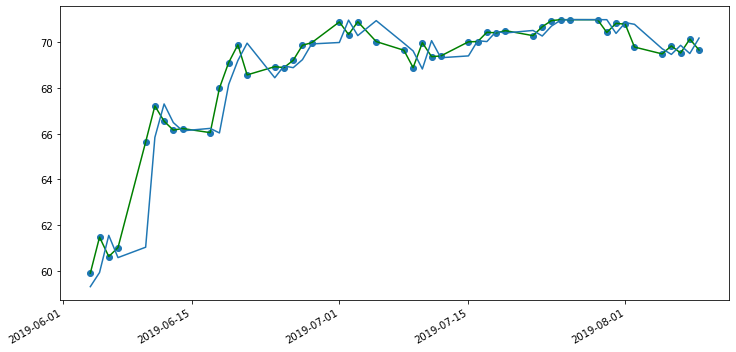

In [32]:
figure, axis = utilities.plot_dataframe(results, "date", "open", scatter=True, line=True)
line = axis.plot(results["date"], results["estimate_open"])

We can now try to improve our estimations by adding an error term to our equation based on a moving average

In [33]:
import statistics

results = []
errors = [0]

# Loop through our data and make predictions
for t in range(datapoints_for_training, datapoint_count):
    
    # Detemine what data is available at this point in time (everything up to and including the previous day)
    data_at_this_point = aaba_dataframe["open"][:t - 1]
    
    # Create the AR model and train it based on the available data
    #     https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.fit.html
    #
    # Note: If we ignore the last two parameters of the ARIMA morel we are left with the AR model
    #
    model = ARIMA(data_at_this_point, order=(p,0,0))
    model_fit = model.fit(trend=trend, disp=False)
    
    # Retrieve the coefficients from the trained model
    ar_coef = model_fit.arparams[0]
    
    # Detemine the previous term
    previous_diff = aaba_dataframe["diff"][t - 1]
    
    # Calculate a moving average of the pervious error terms
    estimate_error = statistics.mean(errors)
    estimate_error = max(errors)
    
    # Make a prediction using the equation    
    estimate_diff = ar_coef * previous_diff + estimate_error
    
    # Determine the actual value
    actual_diff = aaba_dataframe["diff"][t]
    
    # Determine the error and add it to our list of errors
    if len(errors) > 7:
        errors.pop(0)
    actual_error = abs(actual_diff - estimate_diff)
    errors.append(actual_error)
    
    # Determine the predicted price
    previous_open = aaba_dataframe["open"][t - 1]
    estimate_open = previous_open + estimate_diff
    
    # Update our dataframe
    results.append({
        "date": aaba_dataframe["date"][t],
        "open": aaba_dataframe["open"][t],
        "diff": actual_diff,
        "estimate_diff": estimate_diff,
        "estimate_open": estimate_open,
        "coeff": ar_coef,
        "previous_diff": previous_diff,
        "actual_error": actual_error,
        "estimate_error": estimate_error
    })
    
    # print("{0} | {1} = {2} * {3}".format(actual, yhat, ar_coef, previous_y))

results = pandas.DataFrame(results)

c:\program files\python\python 3.8\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
c:\program files\python\python 3.8\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
c:\program files\python\python 3.8\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
c:\program files\python\python 3.8\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:218: RuntimeWarning: divide by zero encountered in true_divide
  loglike, sigma2 = kalman_loglike.kalman_loglike_double(
c:\program files\python\python 3.8\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Invertin

In [34]:
results.head(20)

,date,open,diff,estimate_diff,estimate_open,coeff,previous_diff,actual_error,estimate_error
0,2019-06-04,59.89,0.59,-0.019996,59.280004,0.999793,-0.02,0.609996,0.000000
1,2019-06-05,61.47,1.58,1.199875,61.089875,0.999795,0.59,0.380125,0.609996
2,2019-06-06,60.62,-0.85,2.189678,63.659678,0.999799,1.58,3.039678,0.609996
3,2019-06-07,61.01,0.39,2.189678,62.809678,1.000000,-0.85,1.799678,3.039678
4,2019-06-10,65.64,4.63,3.429600,64.439600,0.999801,0.39,1.200400,3.039678
5,2019-06-11,67.22,1.58,7.668768,73.308768,0.999803,4.63,6.088768,3.039678
6,2019-06-12,66.55,-0.67,7.668444,74.888444,0.999795,1.58,8.338444,6.088768
7,2019-06-13,66.16,-0.39,7.668444,74.218444,1.000000,-0.67,8.058444,8.338444
8,2019-06-14,66.23,0.07,7.948523,74.108523,0.999799,-0.39,7.878523,8.338444
9,2019-06-17,66.05,-0.18,8.408444,74.638444,1.000000,0.07,8.588444,8.338444


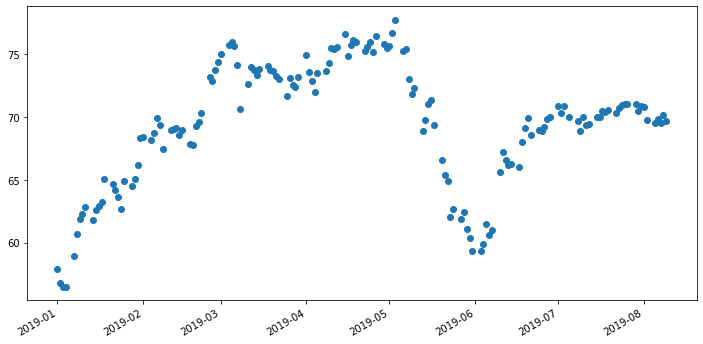

In [35]:
figure, axis = utilities.plot_dataframe(aaba_dataframe, "date", "open")

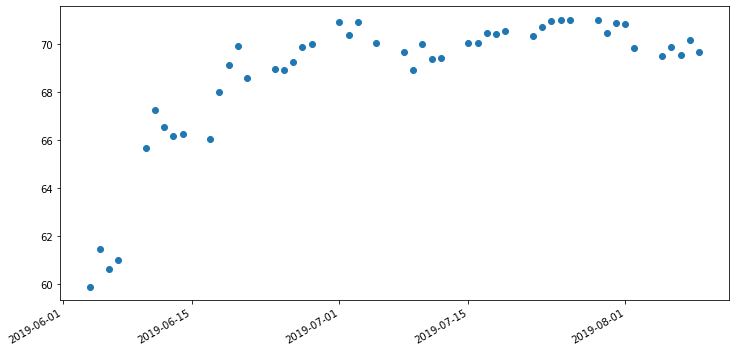

In [36]:
figure, axis = utilities.plot_dataframe(results, "date", "open")
#line = axis.plot(results["date"], results["estimate_open"])

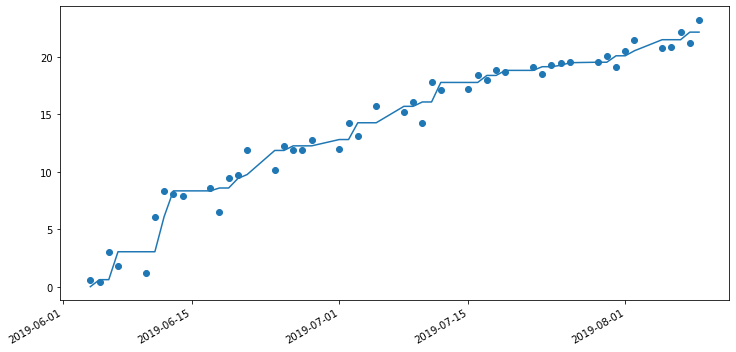

In [39]:
figure, axis = utilities.plot_dataframe(results, "date", "actual_error")
line1 = axis.plot(results["date"], results["estimate_error"])
#line2 = axis.plot(results["date"], numpy.zeros(results["date"].shape[0]))

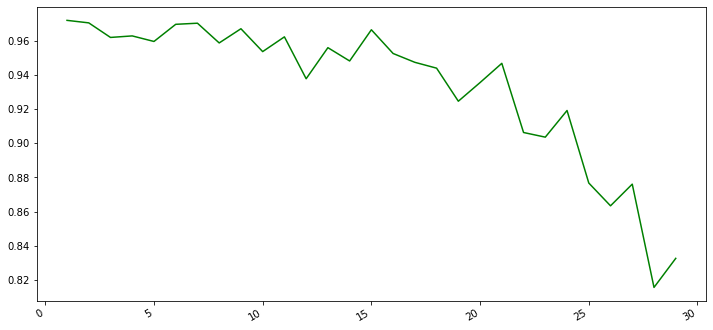

In [38]:
lags = range(1, 30)
autocorrelations = [results["actual_error"].autocorr(lag) for lag in lags]
df = pandas.DataFrame({"lags":lags, "auto": autocorrelations})
figure, axis = utilities.plot_dataframe(df, "lags", "auto", scatter=False, line=True)